## Seasonal 시계열 분석으로 기아 자동차 주식 데이터 분석

- https://gist.github.com/HyeongWookKim/c8f31f30b233896bb8947622d7efaf82

#### 1. library & data load

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from fbprophet import Prophet

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

- '기아자동차(000270)'의 2012 1월 1일부터 2017년 6월 30일까지의 주가 정보를 사용

In [21]:
start_date = '2012-1-1'
end_date = '2017-6-30'

KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,66700.0,67500.0,66000.0,66500.0,53264.144531,701253
2012-01-03,67000.0,68100.0,67000.0,68100.0,54545.687500,1426477
2012-01-04,68900.0,69200.0,68200.0,68700.0,55026.261719,1209007
2012-01-05,69000.0,69200.0,68000.0,68400.0,54785.980469,1436004
2012-01-06,68000.0,68400.0,66300.0,66900.0,53584.531250,1494656


#### 2. data 분석

- 종가(Close)를 기준으로 그래프
    - 종가 : 주식거래의 당일 맨 마지막 거래가 체결된 가격

<AxesSubplot:xlabel='Date'>

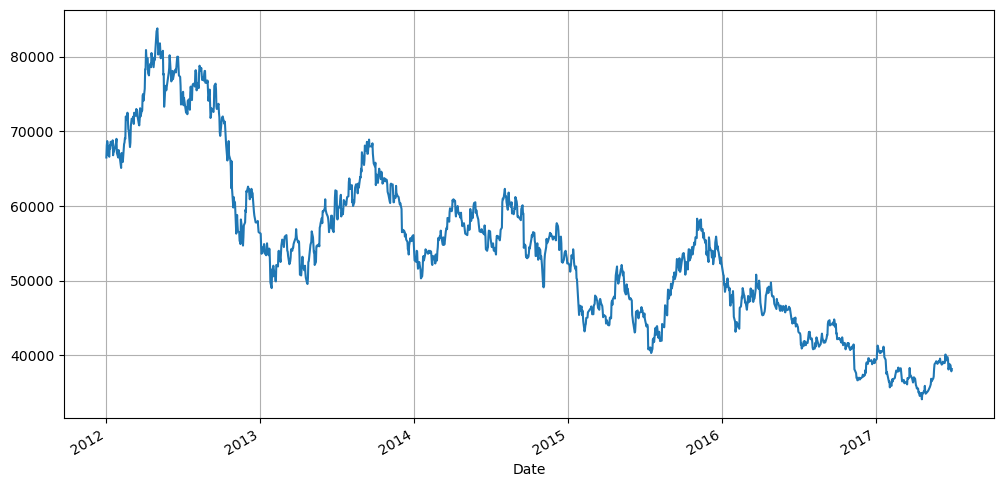

In [22]:
KIA['Close'].plot(figsize = (12, 6), grid = True)

- 나중에 실제 값과의 비교를 위해, 일부 데이터를 잘라서 먼저 forecast를 수행

In [23]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,66700.0,67500.0,66000.0,66500.0,53264.144531,701253
2012-01-03,67000.0,68100.0,67000.0,68100.0,54545.687500,1426477
2012-01-04,68900.0,69200.0,68200.0,68700.0,55026.261719,1209007
2012-01-05,69000.0,69200.0,68000.0,68400.0,54785.980469,1436004
2012-01-06,68000.0,68400.0,66300.0,66900.0,53584.531250,1494656
...,...,...,...,...,...,...
2016-12-23,38700.0,39350.0,38650.0,39100.0,33386.183594,1070783
2016-12-26,39100.0,39350.0,38850.0,39000.0,33300.792969,465612
2016-12-27,39050.0,39700.0,39050.0,39500.0,33727.730469,879686


In [24]:
df = pd.DataFrame({'ds': KIA_trunc.index, 'y': KIA_trunc['Close']})
df.reset_index(inplace = True)

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['Date']

df.head()

,ds,y
0,2012-01-02,66500.0
1,2012-01-03,68100.0
2,2012-01-04,68700.0
3,2012-01-05,68400.0
4,2012-01-06,66900.0


- 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다

In [27]:
m = Prophet(daily_seasonality = True)
m.fit(df)

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.46018
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3234.42    0.00822976        1907.5      0.3779           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3364.29    0.00663195        939.34      0.6329      0.6329      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3467.87     0.0374847       4169.23           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3523.16    0.00129368       456.726           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3544.94    0.00121958       800.395      0.5667      0.5667      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

- 1년(365일) 후. 즉, 2017년 12월 31일까지의 데이터를 예측하겠다는 의미

In [30]:
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
1595,2017-12-25
1596,2017-12-26
1597,2017-12-27
1598,2017-12-28
1599,2017-12-29


In [31]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
1595,2017-12-25,18436.656427,-1400.121089,41133.754471
1596,2017-12-26,18404.642813,-1544.186858,40396.286369
1597,2017-12-27,18203.757421,-2301.995253,41300.561758
1598,2017-12-28,17987.211065,-1771.435249,40393.084295
1599,2017-12-29,17688.963627,-2378.743563,40070.098834


- 앞서 수행했던 그래프와 비슷

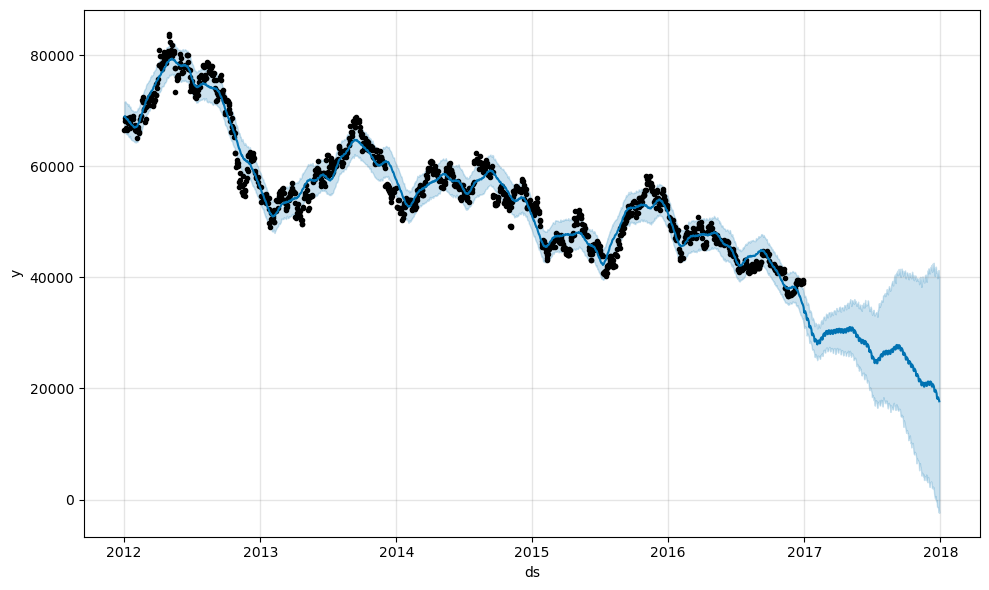

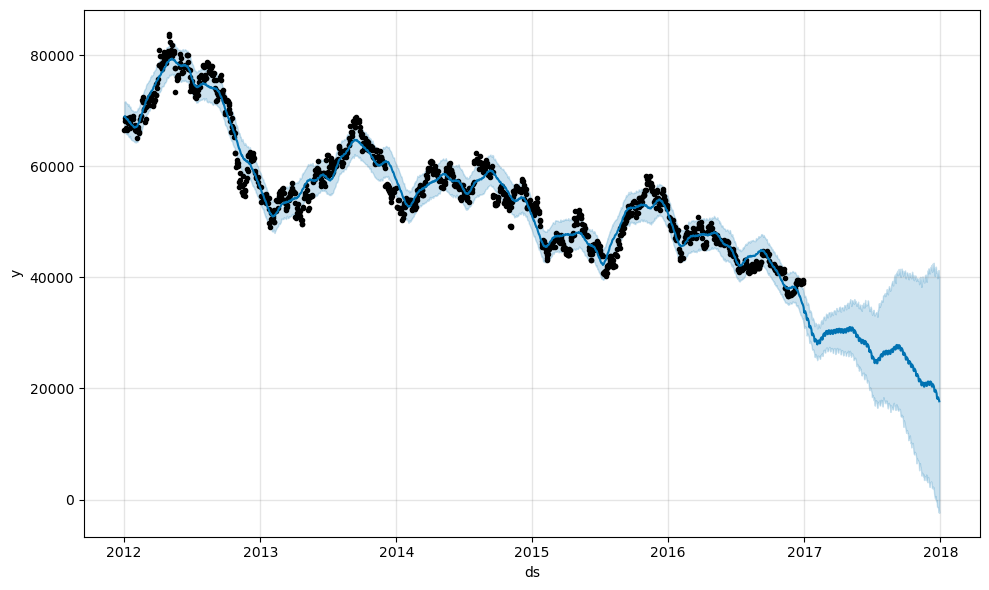

In [32]:
m.plot(forecast)

- 계절성 성분 별로 분해
    - 추세(trend)를 보면, 예측된 부분이 반등되거나 그대로 내려갈 수도 있어보인다
    - 주간(weekly) 데이터를 보면, 주말은 장이 서지 않기 때문에 화요일과 수요일이 상대적으로 높은 주가를 유지
    - 연간(yearly) 데이터를 살펴보면, 기아자동차의 주가는 1년 중에 2월에 가장 낮은 주가를 보이고 5월에 가장 높은 주가

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


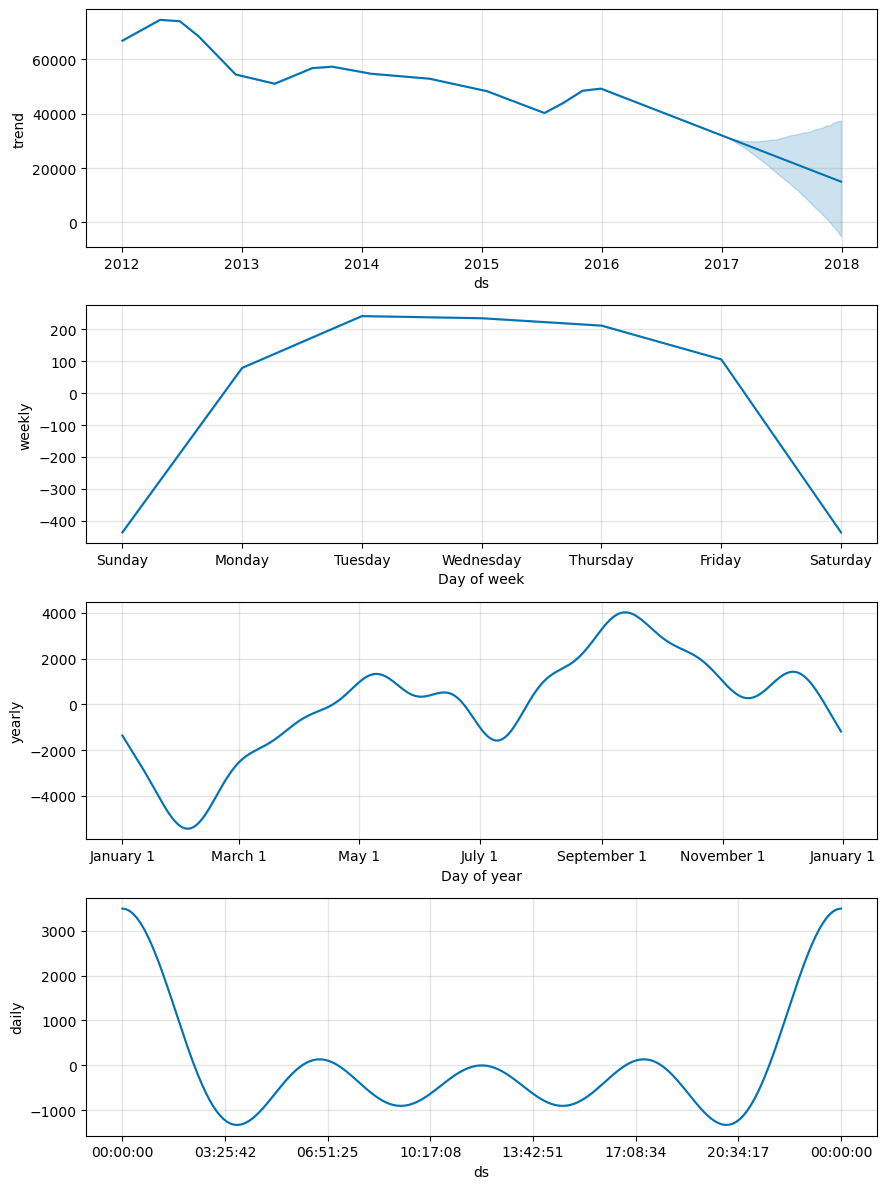

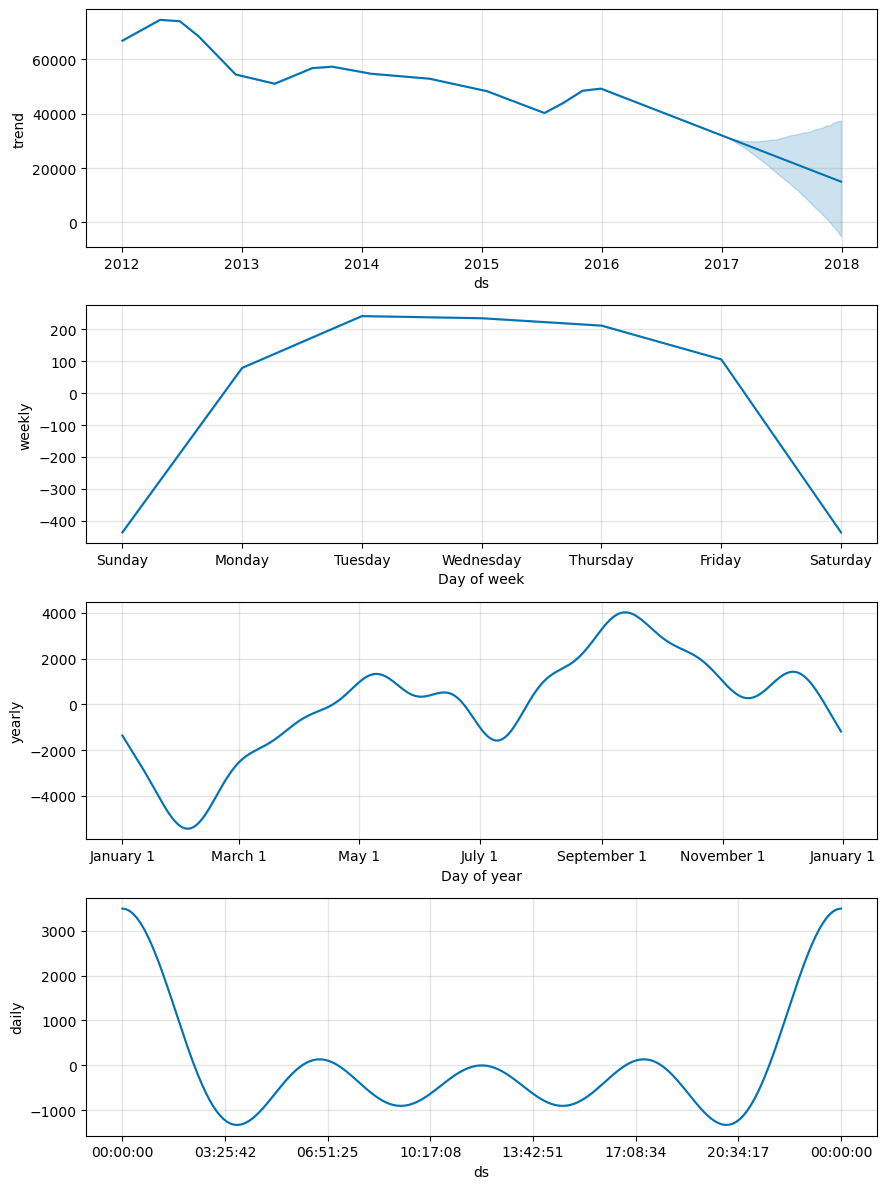

In [33]:
m.plot_components(forecast)

#### 3. 주가를 가져오는 날짜를 변경해서 다시 예측 성능을 확인

- 예측용으로 사용할 데이터는 5월 31일까지
- 종가(Close)를 기준으로 그래프

[*********************100%***********************]  1 of 1 completed


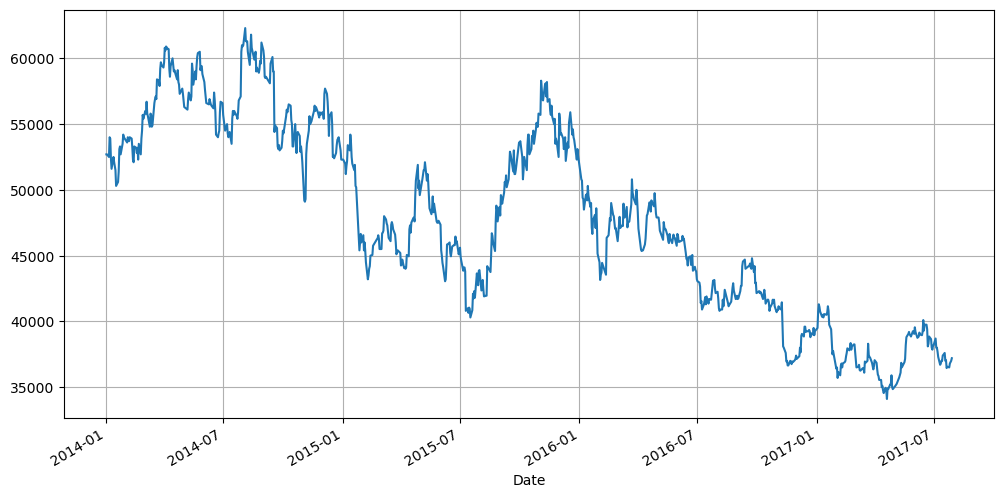

In [34]:
# 받아온 데이터
start_date = '2014-1-1'
end_date = '2017-7-31'

KIA = data.get_data_yahoo('000270.KS', start_date, end_date)

KIA['Close'].plot(figsize = (12, 6), grid = True);

- 받아온 데이터는 2017년 7월 31일까지이며, 예측용으로 사용할 데이터는 5월 31일까지

In [ ]:
# 예측용으로 사용할 데이터
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize = (12, 6), grid = True);

In [35]:
df = pd.DataFrame({'ds': KIA_trunc.index, 'y': KIA_trunc['Close']})
df.reset_index(inplace = True)

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['Date']

In [36]:
df

,ds,y
0,2012-01-02,66500.0
1,2012-01-03,68100.0
2,2012-01-04,68700.0
3,2012-01-05,68400.0
4,2012-01-06,66900.0
...,...,...
1230,2016-12-23,39100.0
1231,2016-12-26,39000.0
1232,2016-12-27,39500.0
1233,2016-12-28,38950.0


In [37]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(daily_seasonality = True)
m.fit(df)

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.46018
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3234.42    0.00822976        1907.5      0.3779           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3364.29    0.00663195        939.34      0.6329      0.6329      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3467.87     0.0374847       4169.23           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3523.16    0.00129368       456.726           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3544.94    0.00121958       800.395      0.5667      0.5667      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [38]:
# 61일 간의 데이터를 예측하겠다는 의미
future = m.make_future_dataframe(periods = 61)
future.tail()

,ds
1291,2017-02-24
1292,2017-02-25
1293,2017-02-26
1294,2017-02-27
1295,2017-02-28


/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


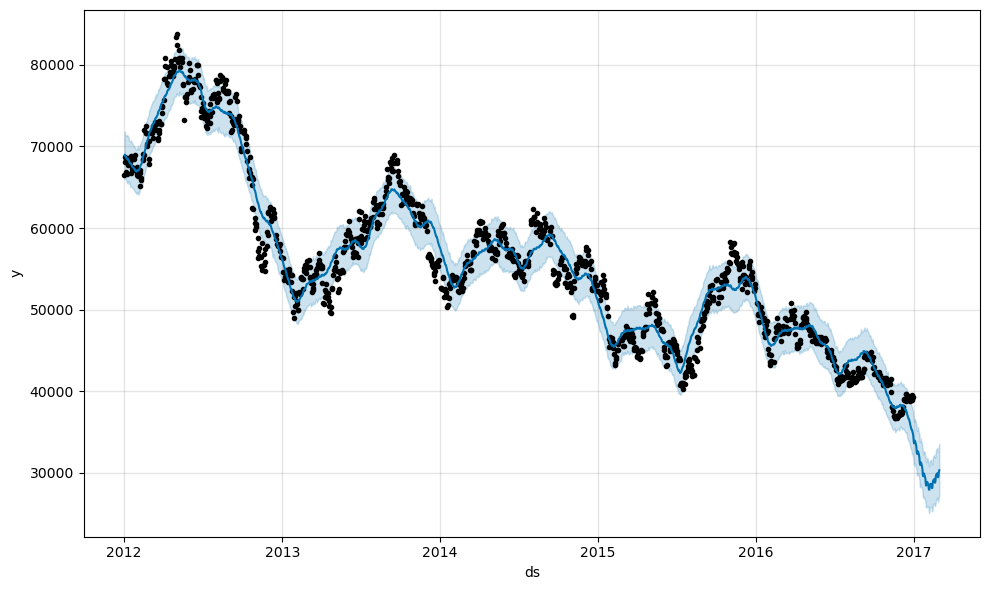

In [39]:
# 예측된 결과를 시각화
forecast = m.predict(future)
m.plot(forecast)

- 실제 데이터 값과 예측 값을 비교

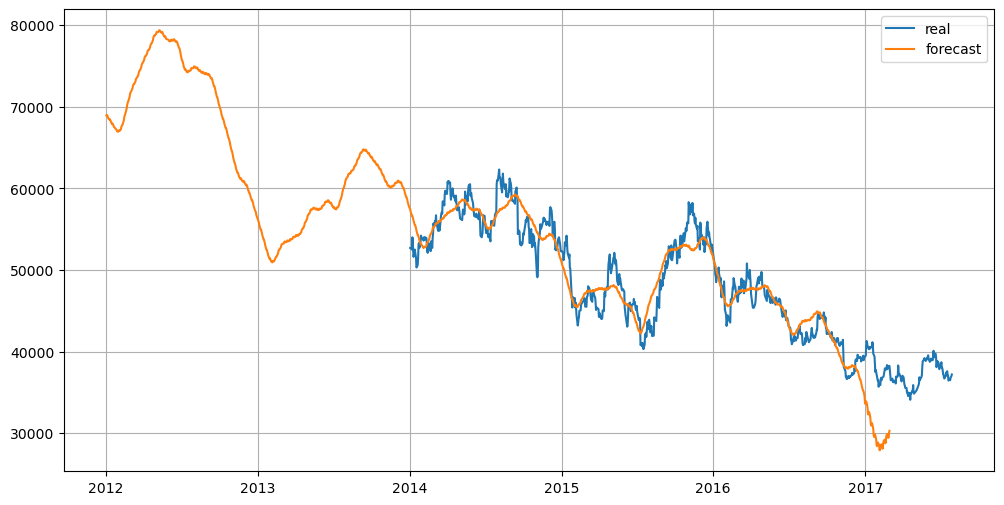

In [40]:
plt.figure(figsize = (12, 6))
plt.plot(KIA.index, KIA['Close'], label = 'real')
plt.plot(forecast['ds'], forecast['yhat'], label = 'forecast')
plt.grid()
plt.legend()
plt.show()